# Measuring the water level of a Theewaterskloof Dam in South Africa

Natebook showcases an example Earth observation processing chain that determines water levels of any water body (dam, reservoir, lake, ...) from satellite imagery. The entire processing chain is performed using the `eo-learn` library. The user simply needs to provide a polygon with water body's nominal water extent.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Imports - eolearn 

In [2]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level 1C) provided through SentinelHub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.
from eolearn.io import S2L1CWCSInput 
from eolearn.core import LoadFromDisk, SaveToDisk

# cloud detection
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

#### Imports - other 

In [3]:
# The golden standard: numpy and matplotlib
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
from shapely.wkt import loads
from shapely.geometry import Polygon

# Sentinel Hub
from sentinelhub import BBox, CRS

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:
1. Download all available Sentinel-2 sattelite imagery of Theewaterskloof Dam from beginning of 2016 and today
    * the following *layers* will be downloaded:
        * `TRUE_COLOR` for nicer visualisations
        * `NDWI` for water detection
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out.
4. Apply adaptive thresholding to `NDWI` grayscale images
5. Extract water level from a comparison of measured water extent from step 4. with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

#### Load the Polygon of nominal water extent and define a BBOX

The BBOX defines an area of interest and will be used to create an EOPatch.

In [4]:
# The polygon of the dam is written in wkt format (CRS=WGS84)
with open('theewaterskloof_dam_nominal.wkt','r') as f:
    dam_wkt = f.read()

dam_nominal = loads(dam_wkt)

# inflate the BBOX 
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds
delx = maxx - minx
dely = maxy - miny

minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
    
dam_bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)

dam_bbox

BBox(((19.10818927, -34.08851246), (19.30962163, -33.977424140000004)), crs=EPSG:4326)

### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [5]:
input_task = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='20m', resy='20m', maxcc=0.5, instance_id=None)
add_ndwi = S2L1CWCSInput('NDWI')

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [6]:
gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'},geometry=[dam_nominal])

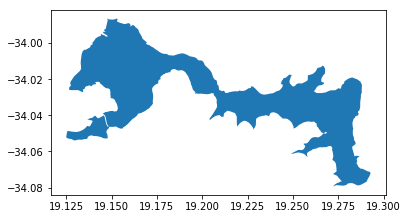

In [7]:
gdf.plot();

In [8]:
add_nominal_water = VectorToRaster((FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), gdf, 1, 
                                   (FeatureType.MASK, 'IS_DATA'), np.uint8)

#### Run s2cloudless cloud detector and filter out scenes with cloud coverage >20%

To speed up the process hte cloud detection is executed at lower resolution (160m). The resulting cloud probability map and binary mask are stored as `CLP` and `CLM` features in EOPatch.

In [9]:
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)

cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=None)

Finished loading model, total used 170 iterations


Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [10]:
class ValidDataPredicate:
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [11]:
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [12]:
def coverage(array):
    return 1.0 - np.count_nonzero(array)/np.size(array)

In [13]:
class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        
        cvrg = np.apply_along_axis(coverage, 1, np.reshape(vld, (vld.shape[0], vld.shape[1]*vld.shape[2])))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', cvrg[:,np.newaxis])
        return eopatch

In [14]:
add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes

In [15]:
class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = 1.0 - np.count_nonzero(array)/np.size(array)
        return coverage < self.threshold

In [16]:
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), ValidDataCoveragePredicate(0.2))

#### Apply Water Detection



In [17]:
def water_detection(ndwi):
    """
    Very simple water detector based on Otsu thresholding method of NDWI.
    """
    otsu_thr = 1.0
    if len(np.unique(ndwi)) > 1:
        otsu_thr = threshold_otsu(ndwi)
    
    return ndwi>otsu_thr

In [18]:
class WaterDetector(EOTask):
    def execute(self, eopatch):
        water_masks = np.asarray([water_detection(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch

In [19]:
water_det = WaterDetector()

### Step 2: Define the EOWorkflow

In [20]:
workflow = LinearWorkflow(input_task, add_ndwi, cloud_det, add_nominal_water, add_valmask, add_coverage,
                          remove_cloudy_scenes, water_det)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until end of August 2018.

In [21]:
time_interval = ['2016-01-01','2018-08-31']

In [22]:
result = workflow.execute({
    input_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

In [23]:
patch = list(result.values())[-1]

Print content of eopatch at the end of the workflow execution

In [24]:
patch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(69, 618, 928, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 618, 928, 1), dtype=float32)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(69, 618, 928, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 618, 928, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(69, 618, 928, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(69, 618, 928, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(69, 618, 928, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(69, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(69, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(618, 928, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: [da

# Plot results

In [25]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [26]:
def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    
    ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal,cmap=plt.cm.Reds)
    ax.imshow(observed,cmap=plt.cm.Blues)
    ax.axis('off')

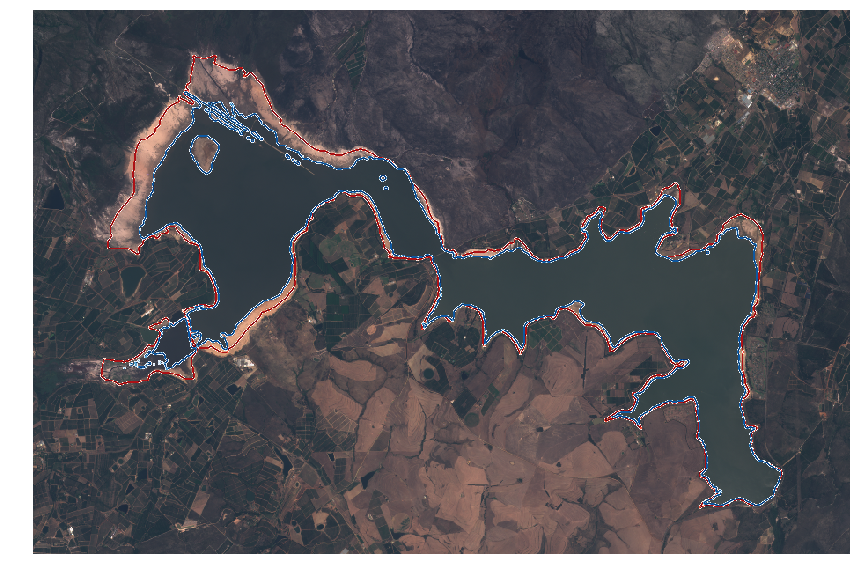

In [27]:
plot_rgb_w_water(patch, 0)

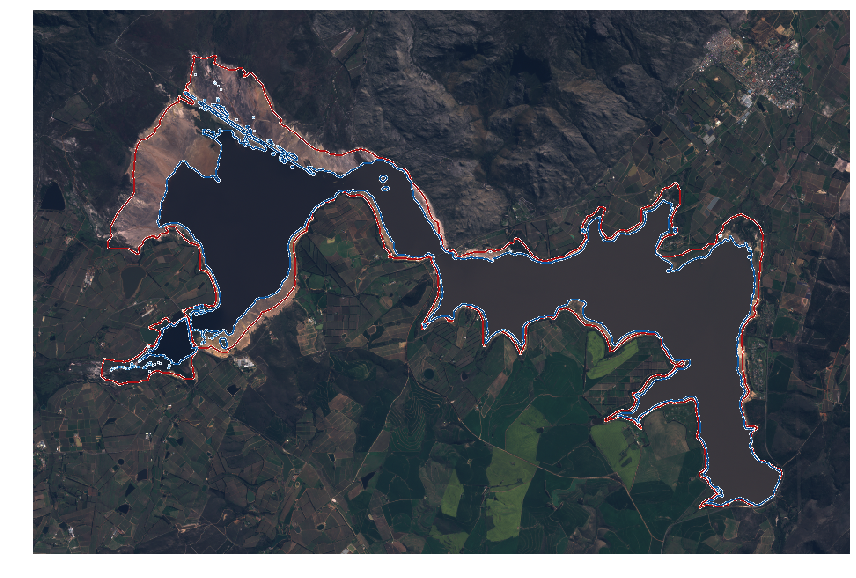

In [28]:
plot_rgb_w_water(patch, -1)

In [29]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7)
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water level')
    ax.set_title('Theewaterskloof Dam Water Levels')
    ax.grid(axis='y')
    return ax

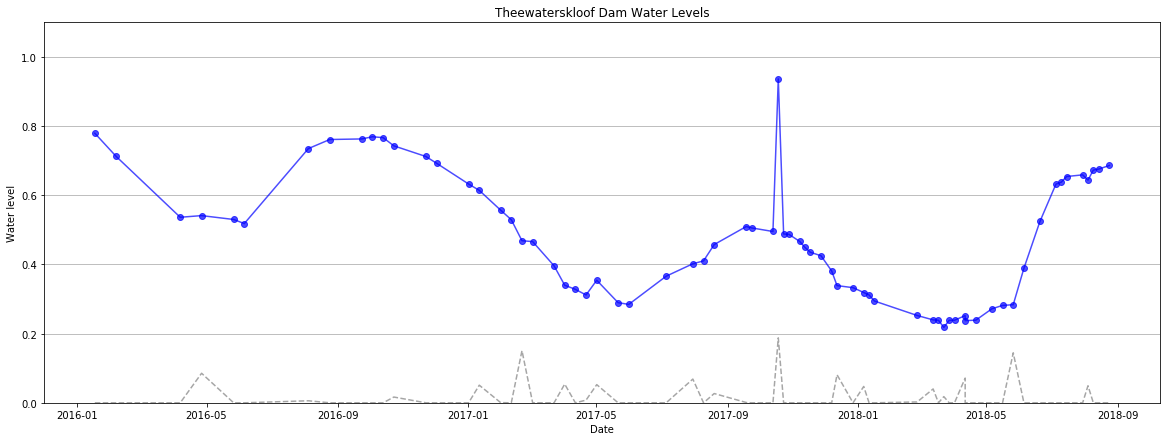

In [30]:
ax = plot_water_levels(patch, 1.0)

One observation at the end of 2017 sticks out. Let's visualise it.

In [31]:
idx = np.where(patch.scalar['WATER_LEVEL']>0.8)[0][0]

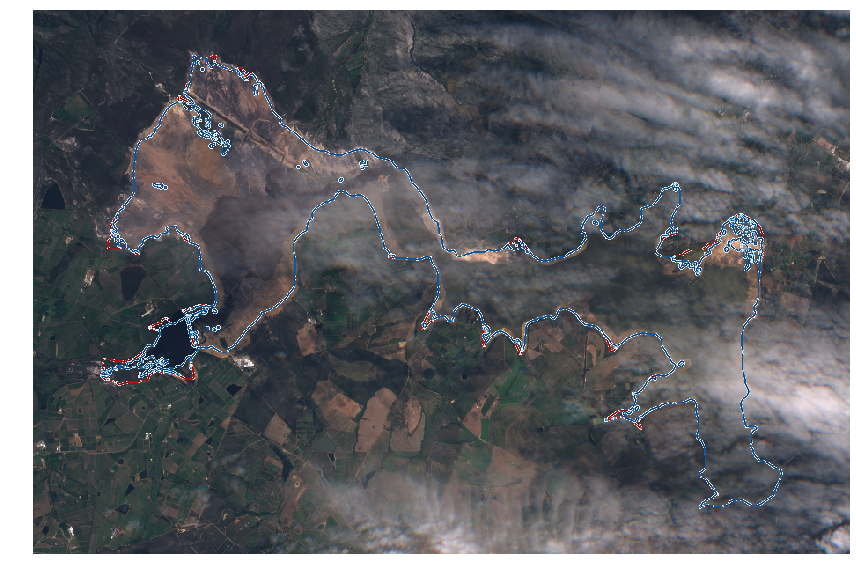

In [32]:
plot_rgb_w_water(patch, idx)

As can be seen the image from this date is covered with clouds, which interfer with water detection algorithms. 
Let's filter the cloudy scene out and plot only water levels for observations with cloud coverage below 2%.

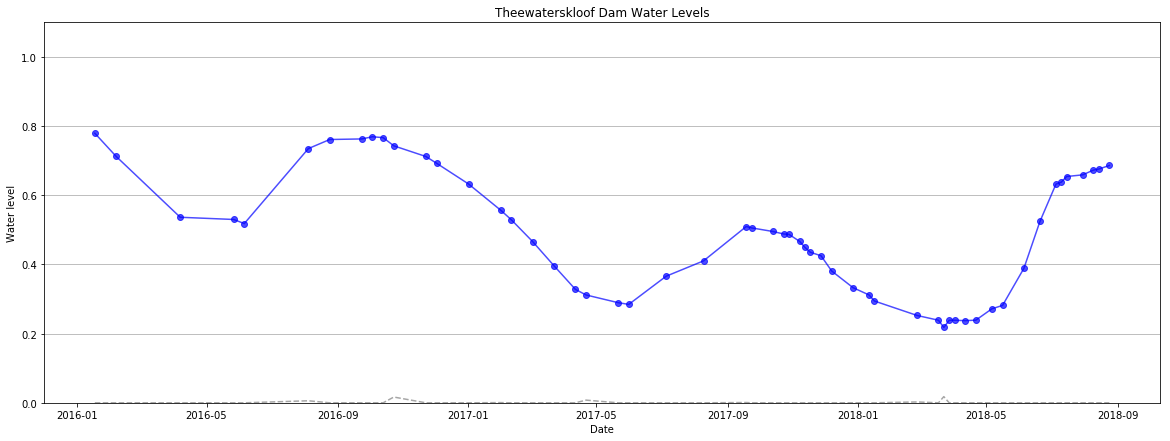

In [33]:
ax = plot_water_levels(patch, 0.02)